In [16]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io

In [17]:
Data_star=pd.read_excel("./脓毒症模型 XG 最终8变量.xlsx")
all_data = np.array(Data_star)
X = all_data[:,1:] #X为所有的X
Y = all_data[:,0:1] #Y为所有的Y
print(X.shape)

(961, 8)


In [18]:
#划分数据集，划分比例是训练集：测试集=0.7：0.3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [20]:
# 最后用
from xgboost import XGBClassifier
classifier = XGBClassifier(base_score=0.9,booster='gbtree',colsample_bylevel=1,colsample_bynode=1,colsample_bytree=1,
                           importance_type='gain',interaction_constraints='',learning_rate=0.3,
                           eta=0.1,gamma=0.001,max_delta_step=0,max_depth=8,min_child_weight=3,
                           n_estimators=37,n_jobs=-1,num_parallel_tree=1,
                           reg_alpha=0,reg_lambda=1,scale_pos_weight=1,
                           tree_method='exact',validate_parameters=1,verbose=1,
                           subsample=1,objective="binary:logistic",eval_metric='logloss',random_state=0) #n_estimators为可调参数，改变n_estimators的数值，预测精度会随之改变
classifier.fit(X_train, y_train)

D:\envs\st_37\lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=0.9, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eta=0.1, eval_metric='logloss', feature_types=None, gamma=0.001,
              grow_policy=None, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=8, max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=37,
              n_jobs=-1, num_parallel_tree=1, ...)

In [21]:
#训练集和测试集预测概率
y_pred = classifier.predict_proba(X_test)[:,1]
y_pred_train = classifier.predict_proba(X_train)[:,1]

In [22]:
#计算训练集和测试集上的AUC
from sklearn.metrics import roc_auc_score
auc_score_test = roc_auc_score(y_test,y_pred)
print(auc_score_test)

auc_score_train = roc_auc_score(y_train,y_pred_train)
print(auc_score_train)


0.9259552042160738
0.9999609354653888


In [23]:
#混淆矩阵设定需求
from numpy import argmax
from sklearn import metrics
def find_optimal_cutoff(fpr,tpr,threshold):
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    return optimal_threshold

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
def best_confusion_matrix(y_test, y_pred):
    tpr,fpr,threshold=metrics.roc_curve(y_test,y_pred,pos_label=1)
    cutoff = find_optimal_cutoff(tpr,fpr,threshold)
    y_pred = list(map(lambda x:1 if x>=cutoff else 0,y_pred))
    TN,FP,FN,TP = confusion_matrix(y_test,y_pred).ravel()
    return cutoff,TN,FN,FP,TP

test_cutoff,TN,FN,FP,TP = best_confusion_matrix(y_test, y_pred)

print(test_cutoff,TN,FN,FP,TP)

0.18560727 195 13 25 56


In [25]:
Sensitivity = TP / (TP + FN)  #灵敏度
Specificity = TN / (TN + FP)  #特异度
Accuracy = (TP + TN) / (TP + TN + FP + FN)  #正确率
Precision = TP / (TP + FP)  #准确率
F1 = 2 * Precision * Sensitivity / (Precision + Sensitivity)  #F1值
Recall = TP / (TP + FN)  #召回率，同灵敏度
PPV = TP / (TP + FP)  #阳性预测值 positive predict
NPV = TN / (TN + FN)  #阴性预测值 negative predict
YoudenIndex = Sensitivity + Specificity - 1
#print(Sensitivity,Specificity,Accuracy,Precision,F1,Recall,PPV,NPV,YoudenIndex)
print(auc_score_test)
print(Sensitivity,Specificity,PPV,NPV,Accuracy,Precision,F1)

0.9259552042160738
0.8115942028985508 0.8863636363636364 0.691358024691358 0.9375 0.8685121107266436 0.691358024691358 0.7466666666666666


In [26]:
#导出拆分结果
import xlwt
import xlrd
filename =xlwt.Workbook() #创建工作簿
sheet1 = filename.add_sheet(u'sheet1',cell_overwrite_ok=True) #创建sheet1
h1=y_train.shape[0]#h1为行数
h2=X_train.shape[1]#h2为列数
for i in range(h1):  #注意有冒号
    for j in range(h2):
        sheet1.write(i,0,float(y_train[i]))  
        sheet1.write(i,j+1,float(X_train[i][j]))   #此处如果没有j+1，会和第一列重叠
sheet2 = filename.add_sheet(u'sheet2',cell_overwrite_ok=True) #创建sheet2
h3=y_test.shape[0]#h1为行数
h4=X_test.shape[1]#h2为列数
for a in range(h3): 
    for b in range(h4): 
        sheet2.write(a,0,float(y_test[a])) 
        sheet2.write(a,b+1,float(X_test[a][b]))    #此处如果没有b+1，会和第一列重叠
#filename.save("real_results.xls")

C:\Users\12410\AppData\Local\Temp\ipykernel_21824\3156555244.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sheet1.write(i,0,float(y_train[i]))
C:\Users\12410\AppData\Local\Temp\ipykernel_21824\3156555244.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sheet2.write(a,0,float(y_test[a]))


In [27]:
#导出验证集存活情况和预测概率
import xlwt  # 将真实值和预测值结果输出到excel
import xlrd
filename =xlwt.Workbook() #创建工作簿
sheet1 = filename.add_sheet(u'sheet1',cell_overwrite_ok=True) #创建sheet
h=y_pred.shape[0]#h为行数
for i in range(h):
    sheet1.write(i,0,float(y_test[i][0]))    #真实值输出
    sheet1.write(i,1,float(y_pred[i]))    #预测值输出
#filename.save("XG test.xls")

#导出训练集存活情况和预测概率
import xlwt  # 将真实值和预测值结果输出到excel
import xlrd
filename =xlwt.Workbook() #创建工作簿
sheet1 = filename.add_sheet(u'sheet1',cell_overwrite_ok=True) #创建sheet
h=y_pred_train.shape[0]#h为行数
for i in range(h):
    sheet1.write(i,0,float(y_train[i][0]))    #真实值输出
    sheet1.write(i,1,float(y_pred_train[i]))    #预测值输出
#filename.save("XG train.xls")

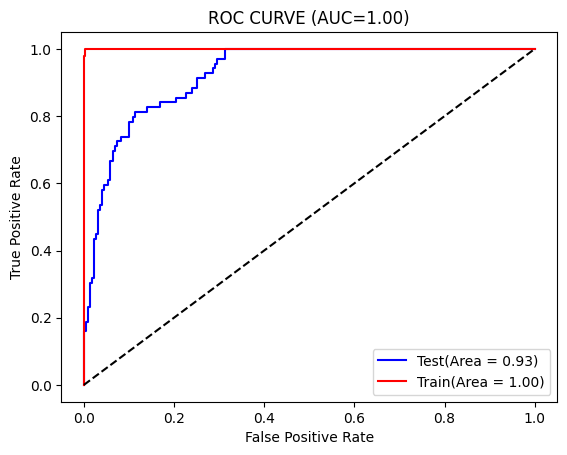

In [28]:
from sklearn.metrics import roc_curve,auc
FPR1,TPR1,threshold1=roc_curve(y_train,y_pred_train,pos_label=1)#测试集的ROC
FPR,TPR,threshold=roc_curve(y_test,y_pred,pos_label=1)#训练集的ROC

#ROC曲线绘制---不同模型的ROC，同一个模型不同数据集下的ROC均可实现
plt.figure()
plt.title('ROC CURVE (AUC={:.2f})'.format(auc_score_train))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.plot(FPR,TPR,color='blue',label='Test(Area = %0.2f)' % auc_score_test)#测试集的ROC
plt.plot(FPR1,TPR1,color='red',label='Train(Area = %0.2f)' % auc_score_train)#训练集的ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc="lower right")
#plt.savefig("XG ROC.jpg",dpi=1000) #可以保存图
plt.show()

In [29]:
#保存模型
import joblib
joblib.dump(classifier, "XGboost_Model.m")

['XGboost_Model.m']